In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision.utils import save_image
import cv2
import matplotlib.pyplot as plt
import random


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#### Downloading the dataset
trainset = torchvision.datasets.MNIST(root='./data', train = True, download = True, transform = transforms.ToTensor())
testset = torchvision.datasets.MNIST(root='./data', train = False, download = True, transform = transforms.ToTensor())
xtrain = trainset.data.numpy()
ytrain = trainset.targets.numpy()
x_val_pre = testset.data[:1000].numpy()
y_val = testset.targets[:1000].numpy()

### Creating x_train and y_train with 1000 images from each class and binarizing the pixels
count = np.zeros(10)
idx = []
for i in range(0, len(ytrain)):
  for j in range(10):
    if(ytrain[i] == j):
      count[j] += 1
      if(count[j]<=1000):
        idx = np.append(idx, i)

y_train = ytrain[idx.astype('int')]
x_train_pre = xtrain[idx.astype('int')]

### Resizing the images from 28x28 to 14x14
r,_,_ = x_train_pre.shape
x_train = np.zeros([r,14,14])
for i in range(r):
  a = cv2.resize(x_train_pre[i].astype('float32'), (14,14)) # Resizing the image from 28*28 to 14*14
  x_train[i] = a

r,_,_ = x_val_pre.shape
x_val = np.zeros([r,14,14])
for i in range(r):
  a = cv2.resize(x_val_pre[i].astype('float32'), (14,14)) # Resizing the image from 28*28 to 14*14
  x_val[i] = a

### Binarizing
x_train = np.where(x_train > 128, 1, 0)
x_val = np.where(x_val > 128, 1, 0)
x_train = x_train.astype(np.float32)
x_val = x_val.astype(np.float32)

### Creating dataloaders
batch_size = 32
trainloader = torch.utils.data.DataLoader([[x_train[i], y_train[i]] for i in range(len(y_train))], shuffle=True, batch_size=batch_size)
testloader = torch.utils.data.DataLoader([[x_val[i], y_val[i]] for i in range(len(y_val))], shuffle=True, batch_size=100)


### Variational Auto Encoder model
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(196, 128) #Encoder
        self.fc21 = nn.Linear(128, 8) #mu
        self.fc22 = nn.Linear(128, 8) #sigma

        self.fc3 = nn.Linear(8, 128) #Decoder
        self.fc4 = nn.Linear(128, 196)

    def encoder(self, x):
        h = torch.tanh(self.fc1(x))
        return self.fc21(h), self.fc22(h) # mu, std

    def sampling(self, mu, std): # Reparameterization trick
        eps1 = torch.randn_like(std)
        eps2 = torch.randn_like(std)
        return 0.5*((eps1 * std + mu) + (eps2 * std + mu)) # Using two samples to compute expectation over z

    def decoder(self, z):
        h = torch.tanh(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mu, std = self.encoder(x.view(-1, 196))
        z = self.sampling(mu, std)
        return self.decoder(z), mu, std
model = VAE()
if torch.cuda.is_available():
    model.cuda()

### Defining loss, optimizer and LR scheduler

optimizer = torch.optim.Adam(model.parameters(), lr = 0.002)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.5,
                             patience=5, threshold=0.001, cooldown=0,
                             min_lr=0.0001, verbose=True)

def loss_function(y, x, mu, std):
    ERR = F.binary_cross_entropy(y, x.view(-1, 196), reduction='sum')
    KLD = -0.5 * torch.sum(1 + torch.log(std**2) - mu**2 - std**2)
    return ERR + KLD, -ERR, -KLD

### Training and Validating

count=0
err_l, kld_l, n_wu, testl, update = [], [], [], [], []
for epoch in range(1, 20):

    train_loss = 0
    for batch_idx, (data, _) in enumerate(trainloader):
        model.train()
        data = data.cuda()
        bsize = data.shape[0]
        recon_batch, mu, std = model(data)
        loss, err, kld = loss_function(recon_batch, data, mu, std)
        loss.backward()
        train_loss += err.item() + kld.item()
        optimizer.step()
        optimizer.zero_grad()
        err_l.append(err.item()/bsize)
        kld_l.append(kld.item()/bsize)
        count+=1
        n_wu.append(count)

        if (count%100 == 0): # Validating every 100 weight updates
          model.eval()
          a, _ = next(iter(testloader))
          a = a.cuda()
          trecon, tmu, tstd = model(a)
          tloss, terr, tkld = loss_function(trecon, a, tmu, tstd)
          testl.append(terr/100)
          update.append(count)

    scheduler.step(train_loss / len(trainloader.dataset))

    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(trainloader.dataset)))
    model.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in testloader:
            data = data.cuda()
            recon, mu, std = model(data)
            loss, err, kld = loss_function(recon, data, mu, std)
            test_loss += err + kld

    test_loss /= len(testloader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))


cuda


100%|██████████| 9912422/9912422 [00:00<00:00, 56412320.87it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 15376452.63it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 70013073.46it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13844861.02it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

====> Epoch: 1 Average loss: -51.9237
====> Test set loss: -41.8644
====> Epoch: 2 Average loss: -40.0656
====> Test set loss: -38.4907
====> Epoch: 3 Average loss: -37.6592
====> Test set loss: -36.8122
====> Epoch: 4 Average loss: -36.4194
====> Test set loss: -36.1173
====> Epoch: 5 Average loss: -35.6951
====> Test set loss: -35.4163
====> Epoch: 6 Average loss: -35.1790
====> Test set loss: -35.1196
====> Epoch: 7 Average loss: -34.7142
====> Test set loss: -34.7103
====> Epoch: 8 Average loss: -34.3999
====> Test set loss: -34.4383
====> Epoch: 9 Average loss: -34.0532
====> Test set loss: -34.1274
====> Epoch: 10 Average loss: -33.7042
====> Test set loss: -33.8595
====> Epoch: 11 Average loss: -33.5366
====> Test set loss: -34.0111
====> Epoch: 12 Average loss: -33.3333
====> Test set loss: -33.5211
====> Epoch: 13 Average loss: -33.1201
====> Test set loss: -33.5508
====> Epoch: 14 Average loss: -33.004

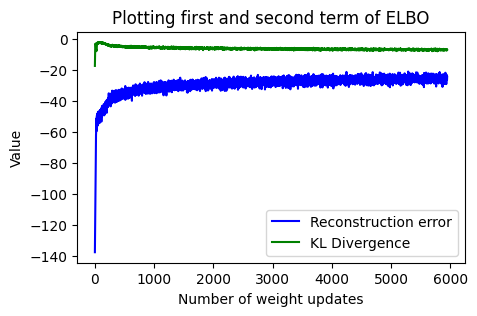

In [2]:
### Plotting the first and second term of ELBO as a function of weight updates

plt.figure(figsize=(5,3), dpi=100)
plt.plot(n_wu, err_l, 'b', label='Reconstruction error')
plt.plot(n_wu, kld_l, 'g', label='KL Divergence')
plt.title('Plotting first and second term of ELBO')
plt.xlabel('Number of weight updates')
plt.ylabel('Value')
plt.legend()



### Correct Labels

<ipython-input-3-49c345b8e2fc>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f, axarr = plt.subplots(1,2)


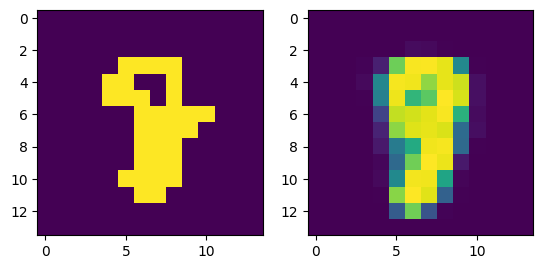

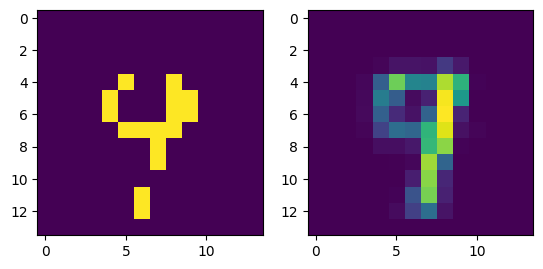

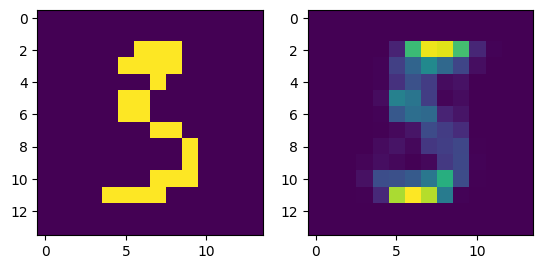

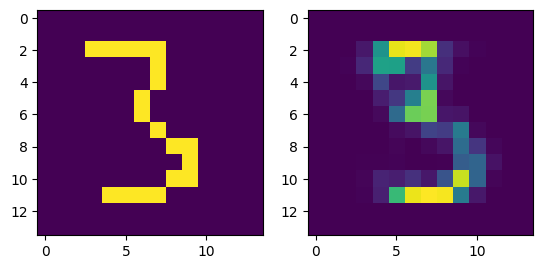

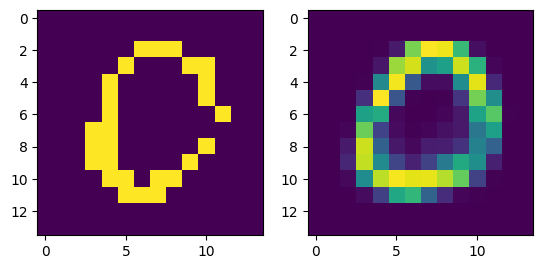

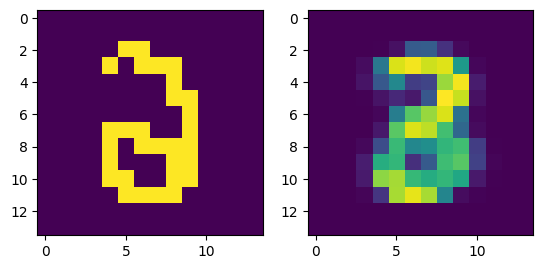

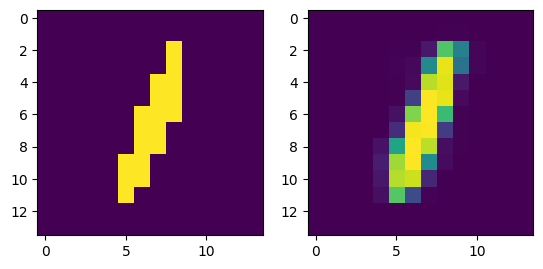

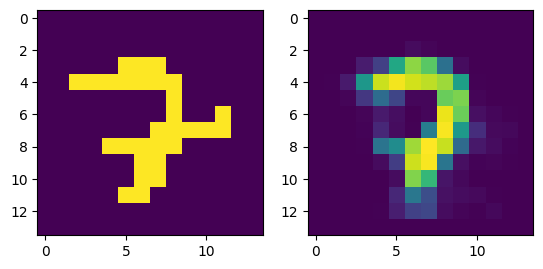

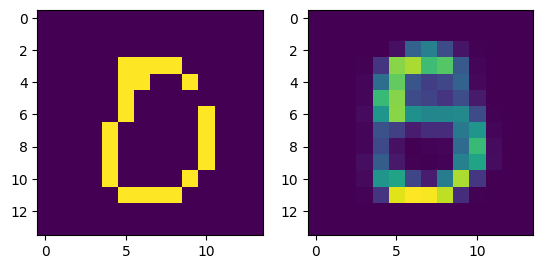

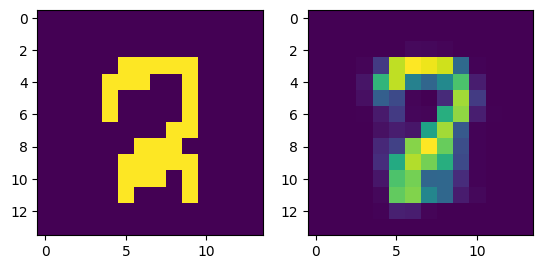

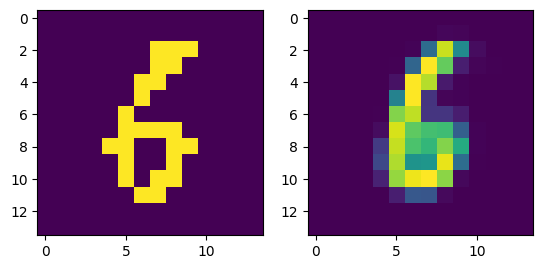

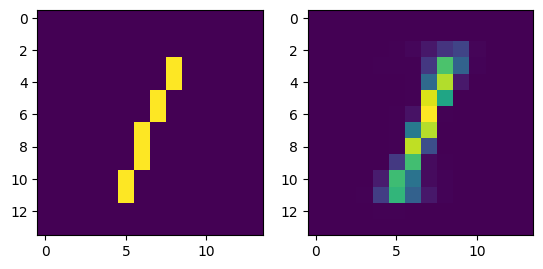

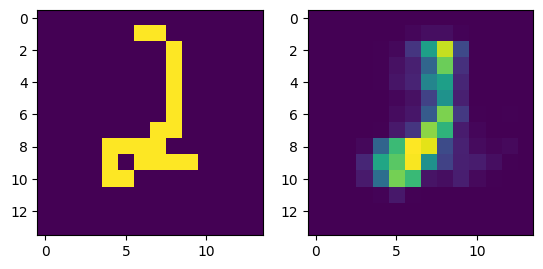

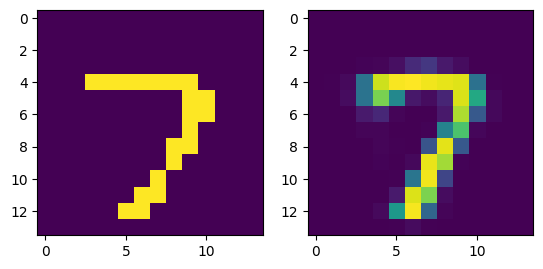

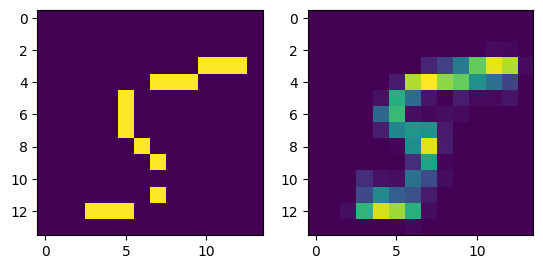

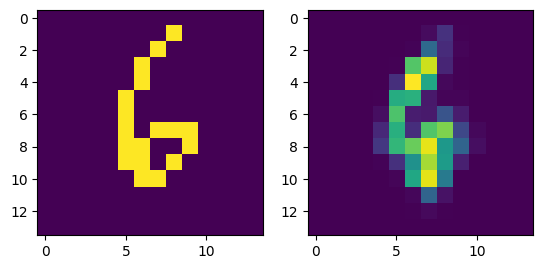

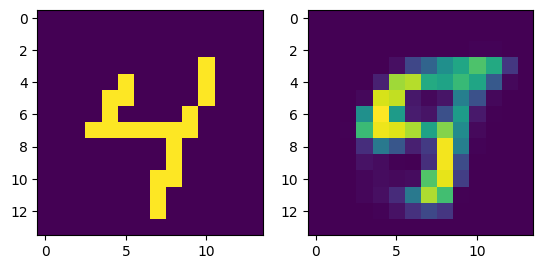

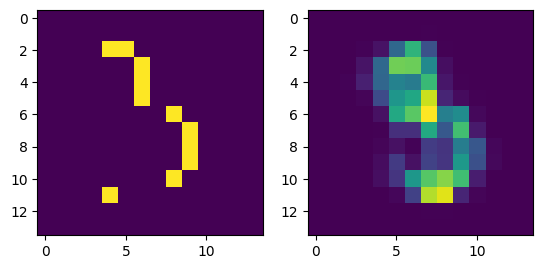

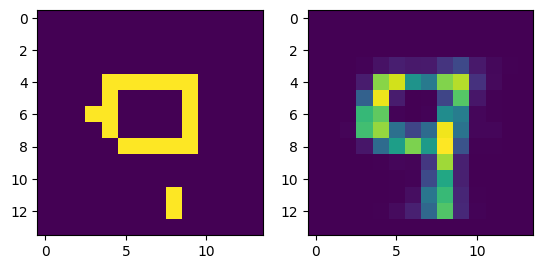

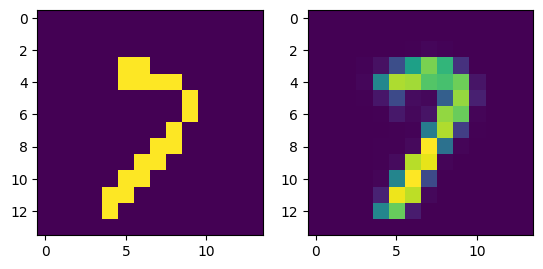

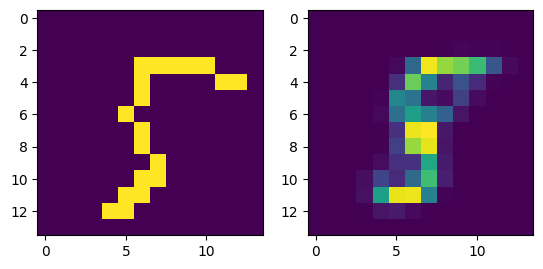

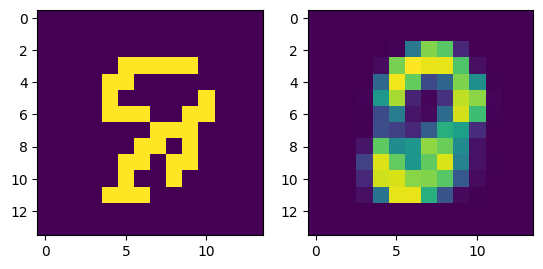

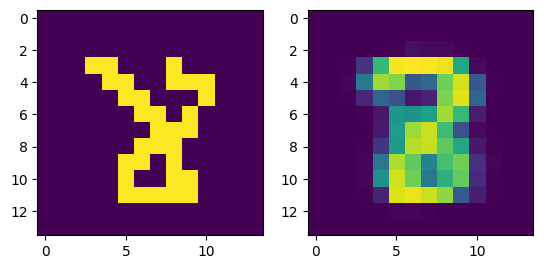

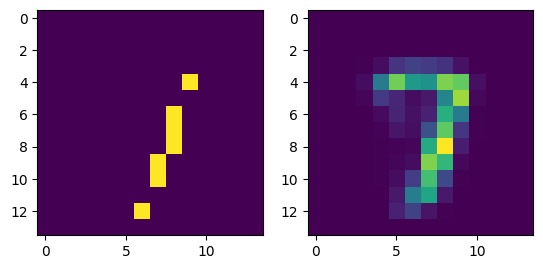

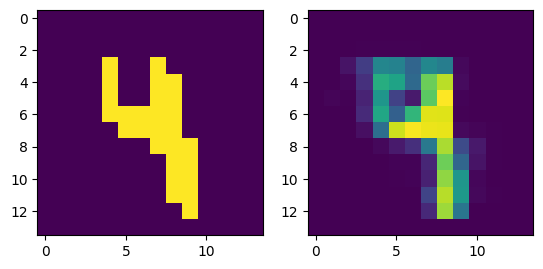

In [3]:
### Visualizing input and output of the VAE from validation set

model.eval()
for i in range(25):
  a,t = next(iter(testloader))
  a = a.cuda()
  recon, mu, std = model(a[0])
  b = recon[0].reshape((14,14))
  f, axarr = plt.subplots(1,2)
  axarr[0].imshow(a[0].detach().cpu().numpy())
  axarr[1].imshow(b.detach().cpu().numpy())

### Incorrect Labels

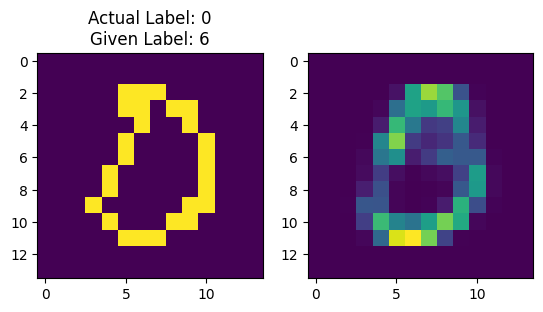

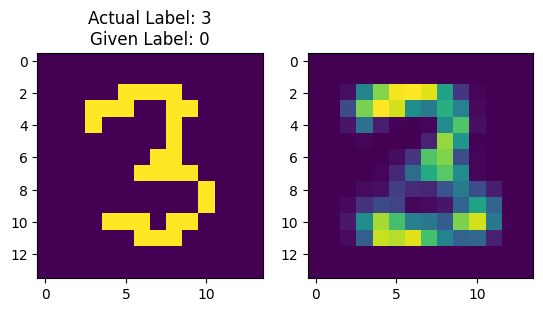

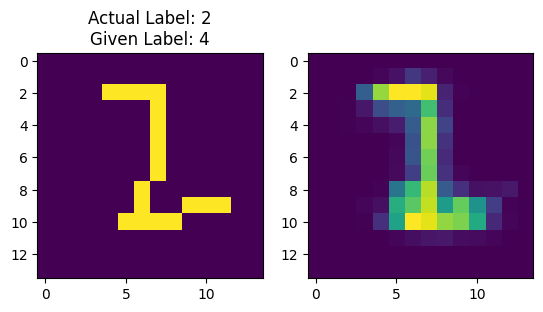

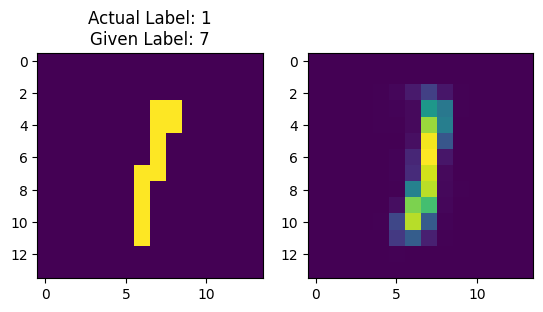

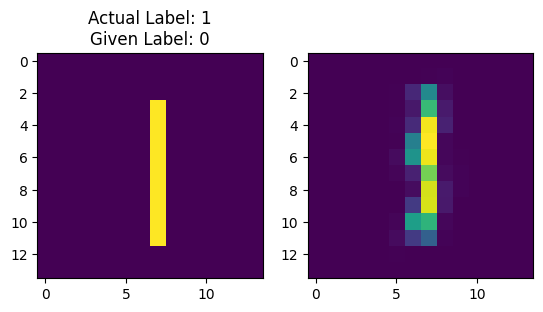

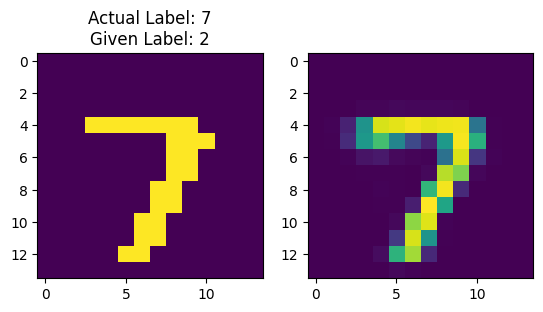

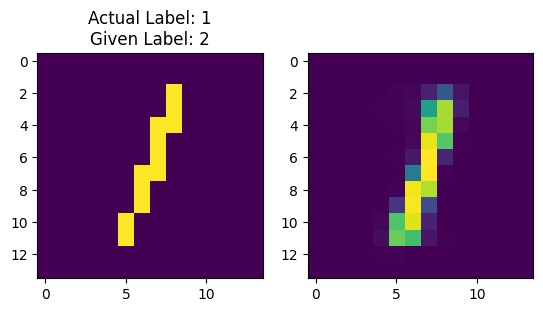

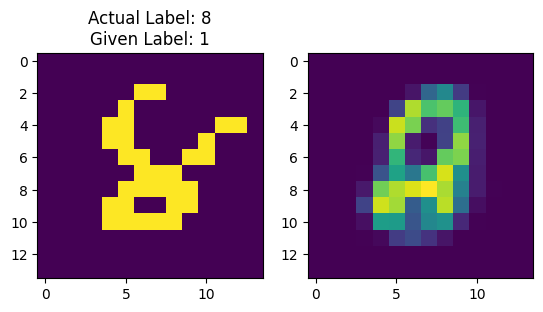

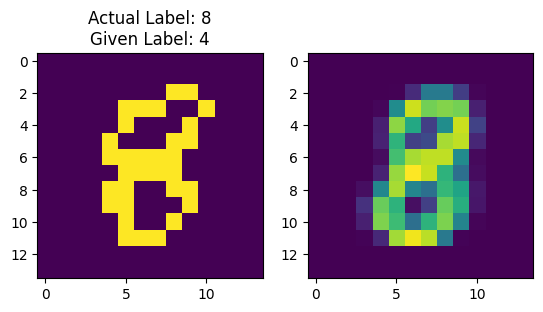

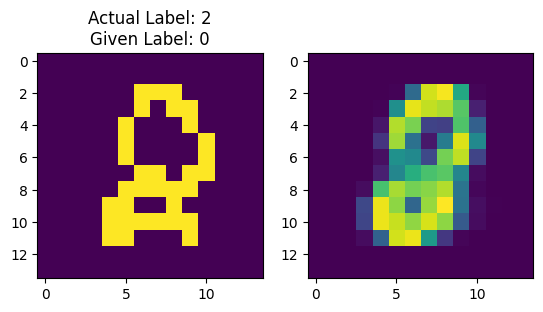

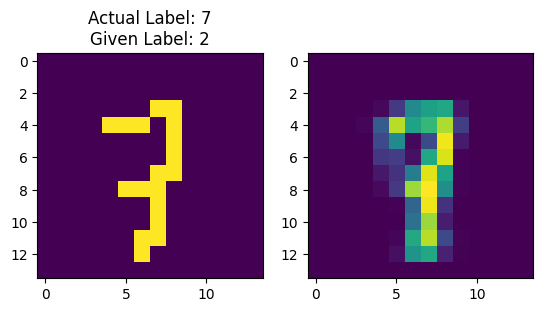

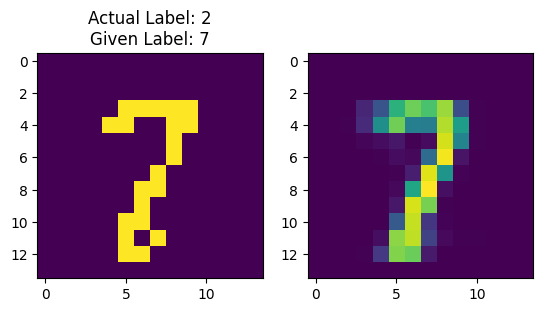

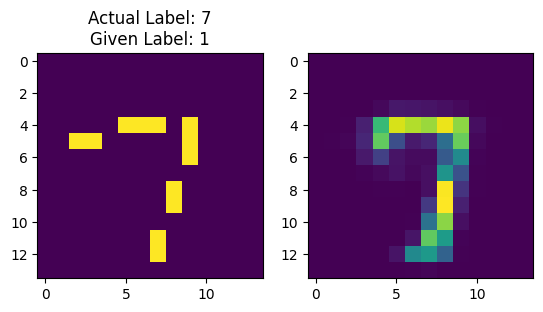

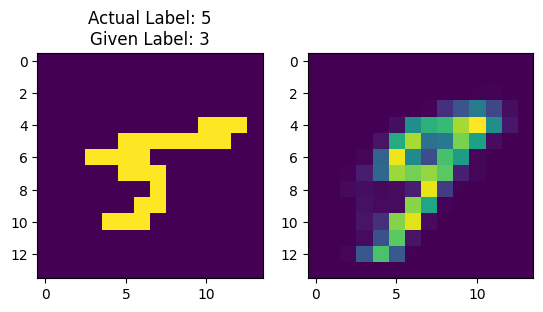

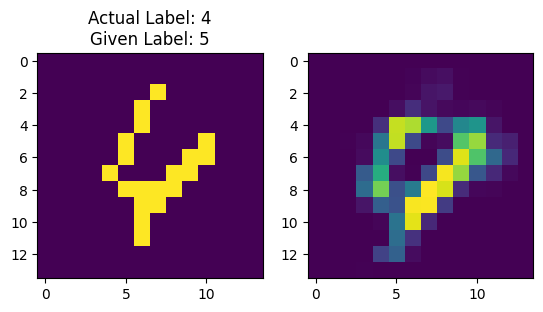

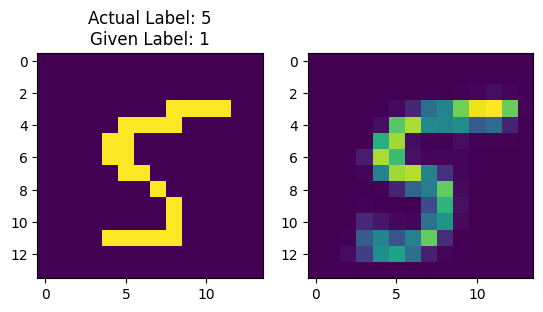

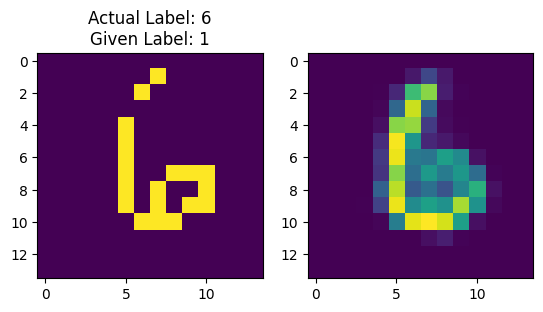

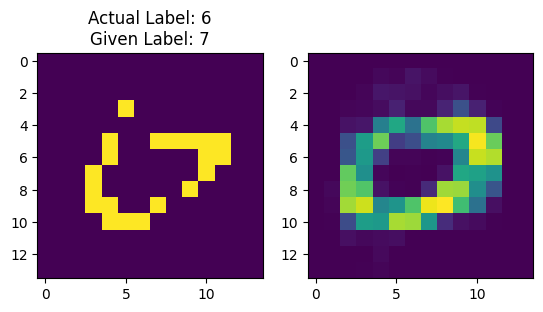

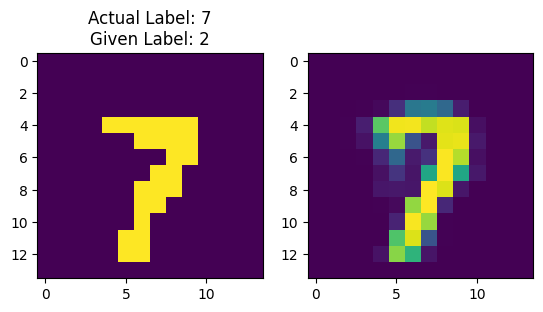

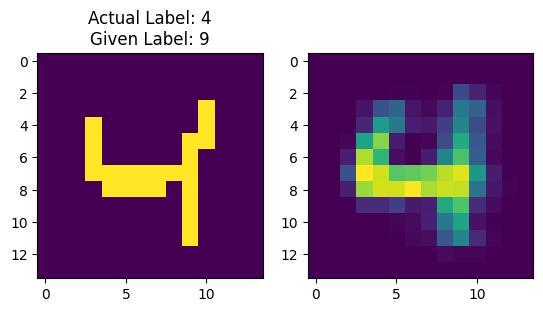

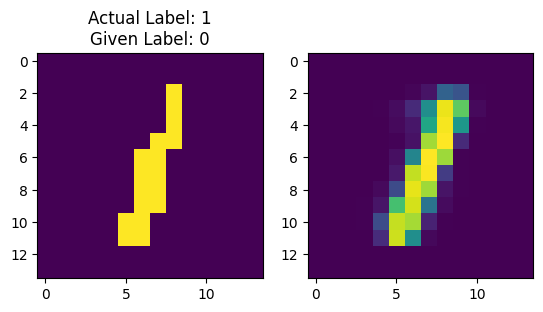

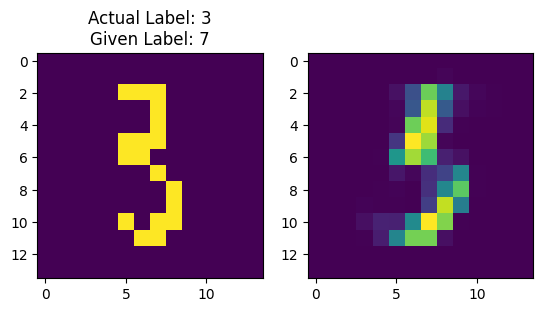

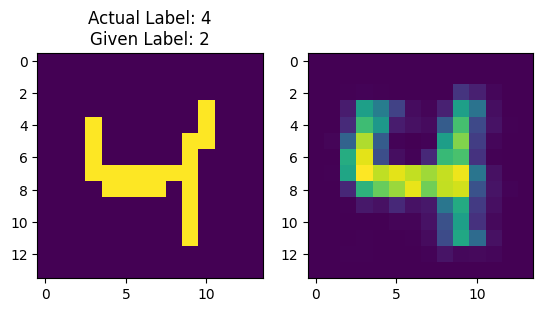

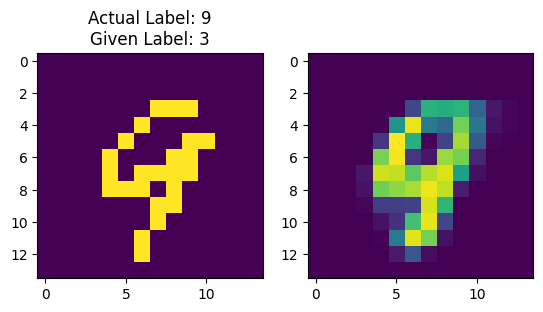

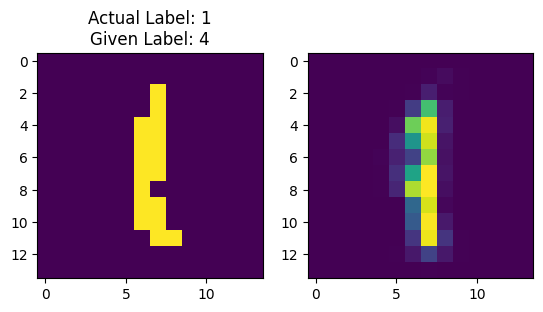

In [4]:
new_x_val = []
new_y_val = []
false_y_val = []

for i in range(25):
    random_index = random.randint(0, len(x_val))
    new_x_val.append(x_val[random_index])
    new_y_val.append(y_val[random_index])

    # Initialize false_label to a value equal to new_y_val
    false_label = y_val[random_index]

    # Generate a new false_label until it's different from new_y_val
    while false_label == y_val[random_index]:
        false_label = random.randint(0, 9)
    false_y_val.append(false_label)

model.eval()

for i in range(25):
    a = new_x_val[i]  # Get the input data as a numpy array
    t = false_y_val[i]  # Get the wrong label

    # Convert the input data to a PyTorch tensor and move it to the GPU if available
    a = torch.tensor(a).unsqueeze(0).cuda() if torch.cuda.is_available() else torch.tensor(a).unsqueeze(0)

    # Forward pass through the model
    recon, mu, std = model(a.view(-1, 196))

    # Get the reconstructed image
    b = recon[0].reshape((14, 14))

    f, axarr = plt.subplots(1, 2)

    # Get the actual label and wrong label
    actual_label = new_y_val[i]  # Actual label assigned for visualization

    axarr[0].imshow(a[0].detach().cpu().numpy())
    axarr[1].imshow(b.detach().cpu().numpy())

    # Set titles for the plots
    axarr[0].set_title(f"Actual Label: {actual_label}\nGiven Label: {t}")

    plt.show()


